# Credit Card Lead Prediction

In [70]:
# !pip install catboost

##  Import the required libraries after installing the required packages

In [71]:
import numpy as np
from numpy import std, mean
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import xgboost as xgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tpot import TPOTClassifier
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

## Load the train and test data sets

In [72]:
# Provide the required paths here
data = pd.read_csv(r"C:\Users\admin\Documents\Python Scripts\Learning\Datasets\Credit_Card_Lead_Prediction\train_s3TEQDk.csv")
test_data = pd.read_csv(r"C:\Users\admin\Documents\Python Scripts\Learning\Datasets\Credit_Card_Lead_Prediction\test_mSzZ8RL.csv")

In [73]:
# Make a copy of the loaded training data

X = data.copy()

In [74]:
# Drop the ID column

X.drop("ID", axis=1,inplace=True)
test_data.drop("ID", axis=1,inplace=True)

## Exploratory Data Analysis

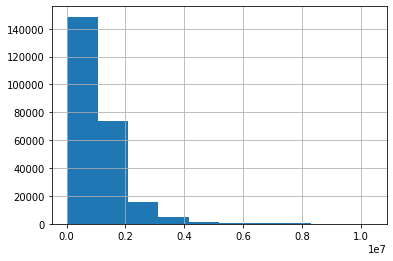

In [75]:
X['Avg_Account_Balance'].hist(bins=10)

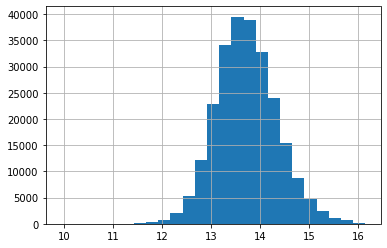

In [76]:
np.log(X['Avg_Account_Balance']).hist(bins=25)

## Data Preparation

### Missing value imputation

In [77]:
np.sum(X.isnull())

Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [78]:
# After checking model performance with 'mode' imputation, I decided to change it to a third category instead of 'mode'

X['Credit_Product'] = X['Credit_Product'].astype(str)
test_data['Credit_Product'] = test_data['Credit_Product'].astype(str)

### Feature Encoding

In [79]:
# Encoding the occupation group based on the income and more chances of lead.
# Used ordinal encoding to preserve the weightage of different occupation groups

oe = OrdinalEncoder(categories=[['Other', 'Salaried', 'Self_Employed', 'Entrepreneur']])
X['OccupationGroup'] =  oe.fit_transform(X.loc[:,['Occupation']])
test_data['OccupationGroup'] =  oe.fit_transform(test_data.loc[:,['Occupation']])
X.drop('Occupation', axis=1,inplace=True)
test_data.drop('Occupation', axis=1,inplace=True)

In [80]:
# Used label encoding for remaining categorical features

le = LabelEncoder()

X['Gender']= le.fit_transform(X['Gender'])
# X['Occupation']= le.fit_transform(X['Occupation'])
X['Credit_Product']= le.fit_transform(X['Credit_Product'])
# X['Vintage']= le.fit_transform(X['Vintage'])
X['Region_Code']= le.fit_transform(X['Region_Code'])
X['Channel_Code']= le.fit_transform(X['Channel_Code'])
X['Age']= le.fit_transform(X['Age'])
X['Is_Active']= le.fit_transform(X['Is_Active'])

test_data['Gender']= le.fit_transform(test_data['Gender'])
# test_data['Occupation']= le.fit_transform(test_data['Occupation'])
test_data['Credit_Product']= le.fit_transform(test_data['Credit_Product'])
# test_data['Vintage']= le.fit_transform(test_data['Vintage'])
test_data['Region_Code']= le.fit_transform(test_data['Region_Code'])
test_data['Channel_Code']= le.fit_transform(test_data['Channel_Code'])
test_data['Age']= le.fit_transform(test_data['Age'])
test_data['Is_Active']= le.fit_transform(test_data['Is_Active'])

### Seperation of target label

In [81]:
# Pop out the target variable

y = X.pop('Is_Lead')

### Class Balancing

In [82]:
# Store the features

features = X.columns

In [83]:
# Use oversampling technique to address class imbalance problem in the dataset

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [84]:
# Convert back to dataframe after oversampling if required

X = pd.DataFrame(X,columns=features)

### Train & Validation Data Splits

In [85]:
trainX, validX, trainY, validY = train_test_split(X,y, test_size=0.2,stratify=y,shuffle=True)

In [86]:
testX = test_data.copy()

### Addressing skewness of the data

In [87]:
# Using log transformation on the account balance feature to remove skewedness which will be helpful
# for gradient boosting algorithms

# X['Avg_Account_Balance'] = np.log(X['Avg_Account_Balance'])
trainX['Avg_Account_Balance'] = np.log(trainX['Avg_Account_Balance'])
validX['Avg_Account_Balance'] = np.log(validX['Avg_Account_Balance'])
testX['Avg_Account_Balance'] = np.log(testX['Avg_Account_Balance'])

### Standardize the account balance column for smooth gradient descent

In [88]:
# standard_scaler = StandardScaler().fit(X.loc[:,['Avg_Account_Balance']])
standard_scaler = StandardScaler().fit(trainX.loc[:,['Avg_Account_Balance']])

In [89]:
# X['Avg_Account_Balance'] = standard_scaler.transform(X.loc[:,['Avg_Account_Balance']])
trainX['Avg_Account_Balance'] = standard_scaler.transform(trainX.loc[:,['Avg_Account_Balance']])
validX['Avg_Account_Balance'] = standard_scaler.transform(validX.loc[:,['Avg_Account_Balance']])

In [90]:
standard_scaler = StandardScaler().fit(testX.loc[:,['Avg_Account_Balance']])
testX['Avg_Account_Balance'] = standard_scaler.transform(testX.loc[:,['Avg_Account_Balance']])

## Model Evaluation

In [91]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

In [92]:
def generate_auc_roc_curve(clf, X_test, Y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

## Using AutoML to find the best model 

In [ ]:
# Following code used AutoML to search for best ML. However, as it is taking lot of time, I left it for future use


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='roc_auc', verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(trainX, trainY)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]

## Building Stacked Models with several well performed models

In [93]:
# get a stacking ensemble of models

def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('xgb', XGBClassifier())) #max_depth=10,n_estimators=100,min_child_weight=1,learning_rate=0.1,gamma=0,subsample=1,colsample_bytree=1,objective='binary:logistic')))
    level0.append(('cat', CatBoostClassifier(iterations=2000))) #, task_type="GPU", devices='0:1')))
    level0.append(('hist', HistGradientBoostingClassifier()))
    level0.append(('lgb', LGBMClassifier()))
    level0.append(('ext', ExtraTreesClassifier()))
    level0.append(('rgb', RandomForestClassifier(n_estimators=100)))

    # define meta learner model
    level1 = XGBClassifier()
    
    # define the hyperparameters. Given lot of hyper parameters is consuming lot of RAM and the session is getting crashed.
    # Hence commented out some parameters
    
    params = {'xgb__max_depth': [5,10,20],
              'xgb__gamma': [0.1,0.2,0.3],
              'xgb__n_estimators': [50,100,200,300],
#               'final_estimator__gamma': [0.1,0.2,0.3],
#               'final_estimator__n_estimators': [50,100,200,300],
#               'ext__max_depth': [5,10,20],
              'xgb__subsample':[i/10.0 for i in range(6,10)],
              'xgb__colsample_bytree':[i/10.0 for i in range(6,10)],
#               'final_estimator__subsample':[i/10.0 for i in range(6,10)],
#               'final_estimator__colsample_bytree':[i/10.0 for i in range(6,10)],
              'xgb__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
#               'final_estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
             }
    

#Need to change here if want to check for best parameters using Grid Search CV

    model = StackingClassifier(estimators=level0, final_estimator=level1)
#     model = GridSearchCV(estimator=sclf, param_grid=params,verbose=2, cv=5,n_jobs=-1)
    return model

In [ ]:
# evaluate a give model using cross-validation

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [ ]:
# This runs the above functions to evaluate model using RKFold
# Only kept for testing purposes

# scores = evaluate_model(model, trainX, trainY)
# print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

In [42]:
# del model

In [66]:
# get the compiled stacked model

model = get_stacking()

In [67]:
# fit the stacked model on the train data

model.fit(trainX, trainY)

Learning rate set to 0.06231
0:	learn: 0.6330357	total: 119ms	remaining: 3m 56s
1:	learn: 0.5866667	total: 247ms	remaining: 4m 6s
2:	learn: 0.5664397	total: 359ms	remaining: 3m 58s
3:	learn: 0.5323824	total: 482ms	remaining: 4m
4:	learn: 0.5182893	total: 593ms	remaining: 3m 56s
5:	learn: 0.4951473	total: 725ms	remaining: 4m
6:	learn: 0.4778606	total: 858ms	remaining: 4m 4s
7:	learn: 0.4588768	total: 987ms	remaining: 4m 5s
8:	learn: 0.4449473	total: 1.11s	remaining: 4m 6s
9:	learn: 0.4376254	total: 1.25s	remaining: 4m 8s
10:	learn: 0.4310808	total: 1.35s	remaining: 4m 4s
11:	learn: 0.4253610	total: 1.46s	remaining: 4m 2s
12:	learn: 0.4202794	total: 1.57s	remaining: 3m 59s
13:	learn: 0.4158937	total: 1.69s	remaining: 4m
14:	learn: 0.4118108	total: 1.8s	remaining: 3m 58s
15:	learn: 0.4082818	total: 1.91s	remaining: 3m 56s
16:	learn: 0.4040325	total: 2.03s	remaining: 3m 56s
17:	learn: 0.4002918	total: 2.16s	remaining: 3m 57s
18:	learn: 0.3932201	total: 2.28s	remaining: 3m 58s
19:	learn: 0.

157:	learn: 0.3074651	total: 19.4s	remaining: 3m 46s
158:	learn: 0.3072321	total: 19.6s	remaining: 3m 46s
159:	learn: 0.3070888	total: 19.7s	remaining: 3m 46s
160:	learn: 0.3070405	total: 19.9s	remaining: 3m 46s
161:	learn: 0.3068228	total: 20s	remaining: 3m 47s
162:	learn: 0.3067893	total: 20.1s	remaining: 3m 46s
163:	learn: 0.3065617	total: 20.3s	remaining: 3m 46s
164:	learn: 0.3065317	total: 20.4s	remaining: 3m 46s
165:	learn: 0.3064445	total: 20.5s	remaining: 3m 46s
166:	learn: 0.3062485	total: 20.7s	remaining: 3m 46s
167:	learn: 0.3062069	total: 20.8s	remaining: 3m 47s
168:	learn: 0.3061791	total: 21s	remaining: 3m 47s
169:	learn: 0.3058111	total: 21.1s	remaining: 3m 47s
170:	learn: 0.3055128	total: 21.2s	remaining: 3m 47s
171:	learn: 0.3051846	total: 21.4s	remaining: 3m 47s
172:	learn: 0.3049961	total: 21.5s	remaining: 3m 47s
173:	learn: 0.3049713	total: 21.6s	remaining: 3m 47s
174:	learn: 0.3049365	total: 21.7s	remaining: 3m 46s
175:	learn: 0.3047059	total: 21.9s	remaining: 3m 4

KeyboardInterrupt: 

## Model Evaluation

In [ ]:
# make predictions with the fitted model on validation set

predY = model.predict(validX)

In [ ]:
# Generate the model evaluation reports

generate_model_report(validY, predY)
generate_auc_roc_curve(model, validX, validY)

## Save the Model

In [ ]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

## Make Submission

In [ ]:
submission = pd.read_csv(r'../input/jobathon-data/sample_submission_eyYijxG.csv')
final_predictions = model.predict_proba(testX)

In [ ]:
final_predictions[:,1]

In [ ]:
submission['Is_Lead'] = final_predictions[:,1]
submission.to_csv('my_submission.csv', index=False)